In [2]:
import pandas as pd
from datetime import datetime
from zoe import cases, query, pickle, find_previous, plot_study, plot_study_evolution

In [3]:
uk_active_cases = query("SELECT * FROM uk_active_cases", index='date')
uk_active_cases.index = pd.to_datetime(uk_active_cases.index, format='%Y%m%d')
uk_active_cases

,cartodb_id,the_geom,the_geom_webmercator,corrected_covid_positive
date,,,,
2020-06-12,22930,None,None,88604.071580
2020-06-13,22931,None,None,81851.113511
2020-06-14,22932,None,None,75630.517112
2020-06-15,22933,None,None,69942.126450
2020-06-16,22934,None,None,64961.649165
...,...,...,...,...
2021-01-06,23138,None,None,775502.856609
2021-01-07,23139,None,None,795678.126957
2021-01-08,23140,None,None,812166.382046


In [4]:
curr_date = uk_active_cases.index.max()
print(pickle(uk_active_cases, 'uk_active_cases', curr_date))

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-01-10_2021-01-10-18-11.pickle


In [5]:
prev_date, prev_uk_active_cases = find_previous(curr_date)

/Users/chris/coronavirus/data/zoe_uk_active_cases_2021-01-09_2021-01-09-17-46.pickle


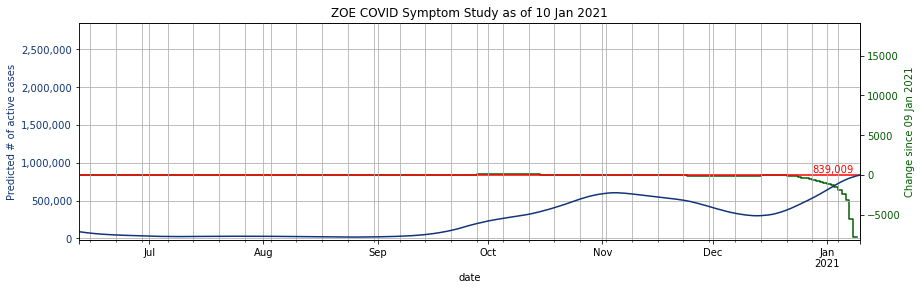

In [6]:
plot_study(curr_date, prev_date, uk_active_cases, prev_uk_active_cases)

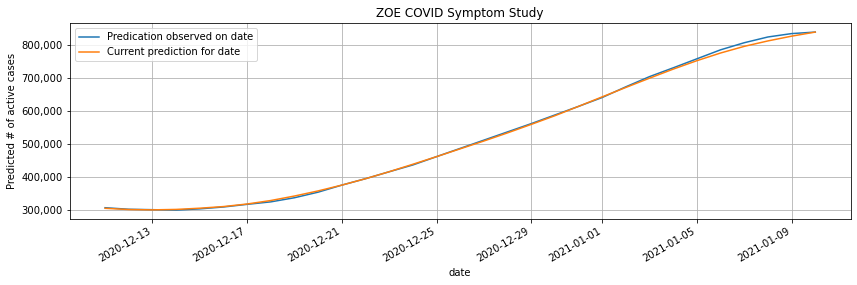

In [7]:
plot_study_evolution(curr_date, days=30)

In [8]:
prevalence_map = query("SELECT * FROM prevalence_map")
prevalence_map['percentage'] = prevalence_map['percentage'].astype(float)

In [9]:
for_date, = prevalence_map['data_status'].unique()
print(pickle(prevalence_map, 'prevalence_map', datetime.strptime(for_date, '%H:%M:%S %d-%m-%Y')))

/Users/chris/coronavirus/data/zoe_prevalence_map_2021-01-10_2021-01-10-18-11.pickle


In [10]:
prevalence_map[['lad16nm', 'lad16cd', 'percentage']].sort_values('percentage', ascending=False)[:10]

,lad16nm,lad16cd,percentage
334,Wrexham,W06000006,4.273568
342,Bridgend,W06000013,3.969142
345,Enfield,E09000010,3.556821
351,Hillingdon,E09000017,3.159660
208,Forest Heath,E07000201,3.137996
375,Southwark,E09000028,3.091809
387,Powys,W06000023,3.083613
370,Redbridge,E09000026,3.053644
379,Tower Hamlets,E09000030,2.884039
343,Vale of Glamorgan,W06000014,2.844847
